# 🛢️ Real Data Well Production Simulation

This notebook combines **fact table** (actual production data) and **dimension table** (decline parameters)
to simulate wells using real historical data where available, and decline curves for forecasting.

## Workflow:
1. Load fact (`houston_fact_combined_cleaned.csv`) and dimension (`qi_di_b_factor_dimension.csv`) data
2. Merge using keys: `["country","market_id","basin_name","well_type","start_year"]`
3. Use actual production data when available, decline parameters for forecasting
4. Run simulation and analyze results

## 1. Setup & Imports

In [2]:
# Standard imports
import sys
import math
from pathlib import Path
from datetime import datetime, timedelta, date
import polars as pl
from typing import Dict, List, Any, Optional

# Data analysis
import polars as pl
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Configure display
pl.Config.set_tbl_rows(50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Helper function for date conversion
def convert_polars_date_to_datetime(polars_date):
    """Convert Polars date object to Python datetime object."""
    if hasattr(polars_date, 'year') and hasattr(polars_date, 'month') and hasattr(polars_date, 'day'):
        # Polars date object - convert to datetime
        return datetime.combine(polars_date, datetime.min.time())
    else:
        # Already a datetime or other format
        return polars_date

print("📚 Imports loaded successfully!")

📚 Imports loaded successfully!


In [3]:
# Import simulation modules
from simulation import SimulationRunner, BasinModel, WellAgent
from config.simulation_config import (
    WellType, DeclineType, DriveMechanism, WellConfiguration,
    WELL_TYPE_PARAMETERS, CONSTANTS,
)

print("🎯 Simulation modules loaded!")

🎯 Simulation modules loaded!


## 2. Load Data

In [4]:
# Load fact table (actual production data)
print("📂 Loading fact data...")
fact = pl.read_csv("data/houston_fact_combined_cleaned.csv")

# Add date column
fact = fact.with_columns([
    pl.col('production_vol_date').str.to_date().alias('prod_date')
])

print(f"✅ Fact table: {fact.shape[0]:,} rows × {fact.shape[1]} columns")
fact.head(5)

📂 Loading fact data...
✅ Fact table: 2,669,582 rows × 15 columns


📂 Loading fact data...
✅ Fact table: 2,669,582 rows × 15 columns


shape: (5, 15)
┌────────────┬────────────┬───────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Unnamed: 0 ┆ api        ┆ basin ┆ play_type  ┆ … ┆ market_id ┆ well_type ┆ basin_nam ┆ prod_date │
│ ---        ┆ ---        ┆ ---   ┆ ---        ┆   ┆ ---       ┆ ---       ┆ e         ┆ ---       │
│ i64        ┆ i64        ┆ str   ┆ str        ┆   ┆ str       ┆ str       ┆ ---       ┆ date      │
│            ┆            ┆       ┆            ┆   ┆           ┆           ┆ str       ┆           │
╞════════════╪════════════╪═══════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1967147    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆           ┆ NAL       ┆ COAST     ┆ 1         │
│            ┆            ┆ BASIN ┆            ┆   ┆           ┆ ONSHORE   ┆ BASIN     ┆           │
│ 1967148    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆           ┆ NAL       ┆ COAST     ┆ 2         │
│            ┆            ┆ BASIN ┆            ┆   ┆           ┆ ONSHORE   ┆ BASIN     ┆           │
│ 1967149    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆           ┆ NAL       ┆ COAST     ┆ 3         │
│            ┆            ┆ BASIN ┆            ┆   ┆           ┆ ONSHORE   ┆ BASIN     ┆           │
│ 1967150    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆           ┆ NAL       ┆ COAST     ┆ 4         │
│            ┆            ┆ BASIN ┆            ┆   ┆           ┆ ONSHORE   ┆ BASIN     ┆           │
│ 1967151    ┆ 4201500075 ┆ GULF  ┆ CONVENTION ┆ … ┆ Houston   ┆ CONVENTIO ┆ GULF      ┆ 2020-01-0 │
│            ┆ 0000       ┆ COAST ┆ AL ONSHORE ┆   ┆           ┆ NAL       ┆ COAST     ┆ 5         │
│            ┆            ┆ BASIN ┆            ┆   ┆           ┆ ONSHORE   ┆ BASIN     ┆           │
└────────────┴────────────┴───────┴────────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [5]:
# Load dimension table (decline parameters)
print("📂 Loading dimension data...")
dim = pl.read_csv("data/qi_di_b_factor_dimension.csv")

print(f"✅ Dimension table: {dim.shape[0]:,} rows × {dim.shape[1]} columns")
dim.head(5)

📂 Loading dimension data...
✅ Dimension table: 17,209 rows × 10 columns


📂 Loading dimension data...
✅ Dimension table: 17,209 rows × 10 columns


shape: (5, 10)
┌────────────┬───────────┬────────────┬────────────┬───┬─────────┬──────────┬───────────┬──────────┐
│ country    ┆ market_id ┆ basin_name ┆ sub_basin_ ┆ … ┆ Qi      ┆ Di       ┆ model     ┆ b_factor │
│ ---        ┆ ---       ┆ ---        ┆ name       ┆   ┆ ---     ┆ ---      ┆ ---       ┆ ---      │
│ str        ┆ str       ┆ str        ┆ ---        ┆   ┆ f64     ┆ f64      ┆ str       ┆ f64      │
│            ┆           ┆            ┆ str        ┆   ┆         ┆          ┆           ┆          │
╞════════════╪═══════════╪════════════╪════════════╪═══╪═════════╪══════════╪═══════════╪══════════╡
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 10530.0 ┆ 0.862826 ┆ null      ┆ null     │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 7343.5  ┆ 0.452474 ┆ hyperboli ┆ 0.45     │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆ c         ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 7343.5  ┆ 0.452474 ┆ exponenti ┆ 0.025    │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆ al        ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ null      ┆ null       ┆ null       ┆ … ┆ 7343.5  ┆ 0.452474 ┆ harmonic  ┆ 1.0      │
│ STATES OF  ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
│ UNITED     ┆ Cushing   ┆ AMARILLO   ┆ AMARILLO   ┆ … ┆ 674.5   ┆ 1.608565 ┆ hyperboli ┆ 0.45     │
│ STATES OF  ┆           ┆ UPLIFT     ┆ UPLIFT     ┆   ┆         ┆          ┆ c         ┆          │
│ AMERICA    ┆           ┆            ┆            ┆   ┆         ┆          ┆           ┆          │
└────────────┴───────────┴────────────┴────────────┴───┴─────────┴──────────┴───────────┴──────────┘

## 3. Prepare Data for Merging

Add merge keys to fact table and prepare dimension table.

In [6]:
# Add merge keys to fact table
fact = fact.with_columns([
    pl.lit("UNITED STATES OF AMERICA").alias("country"),
    pl.lit("Houston").alias("market_id"),
    pl.col("play_type").alias("well_type"),
    pl.col("basin").alias("basin_name")
])

# Select relevant columns from dimension table
dim_columns = ["country", "market_id", "basin_name", "well_type", "start_year", "Qi", "Di", "model", "b_factor"]
dim_subset = dim.select(dim_columns)

print("🔧 Data prepared for merging")
print(f"Dimension columns: {dim_subset.columns}")

🔧 Data prepared for merging
Dimension columns: ['country', 'market_id', 'basin_name', 'well_type', 'start_year', 'Qi', 'Di', 'model', 'b_factor']


## 4. Create Well Summary from Fact Table

In [7]:
# Get summary for each well from fact table
well_summary = (
    fact
    .group_by('api')
    .agg([
        pl.col('prod_date').min().alias('first_prod_date'),
        pl.col('prod_date').max().alias('latest_prod_date'),
        pl.col('bopd').first().alias('first_bopd'),
        pl.col('bopd').last().alias('last_bopd'),
        pl.col('bopd').mean().alias('avg_bopd'),
        pl.col('bopd').max().alias('max_bopd'),
        pl.col('bopd').sum().alias('total_oil'),
        pl.col('play_type').first().alias('play_type'),
        pl.col('basin').first().alias('basin'),
        pl.col('production_status').last().alias('status'),
        pl.col('start_year').first().alias('start_year'),
        pl.len().alias('days_of_data'),
    ])
    .sort('total_oil', descending=True)
)

# Add merge keys
well_summary = well_summary.with_columns([
    pl.lit("UNITED STATES OF AMERICA").alias("country"),
    pl.lit("Houston").alias("market_id"),
    pl.col("play_type").alias("well_type"),
    pl.col("basin").alias("basin_name")
])

print(f"📊 Well summary created: {well_summary.shape[0]:,} unique wells")
well_summary.head(10)

📊 Well summary created: 1,563 unique wells


shape: (10, 17)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ api       ┆ first_pro ┆ latest_pr ┆ first_bop ┆ … ┆ country   ┆ market_id ┆ well_type ┆ basin_na │
│ ---       ┆ d_date    ┆ od_date   ┆ d         ┆   ┆ ---       ┆ ---       ┆ ---       ┆ me       │
│ i64       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ str       ┆ str       ┆ str       ┆ ---      │
│           ┆ date      ┆ date      ┆ f64       ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 427064042 ┆ 2020-01-0 ┆ 2025-09-3 ┆ 816.70967 ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF     │
│ 70002     ┆ 1         ┆ 0         ┆ 7         ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST    │
│           ┆           ┆           ┆           ┆   ┆ AMERICA   ┆           ┆ OFFSHORE  ┆ BASIN    │
│ 427064047 ┆ 2022-03-0 ┆ 2025-09-3 ┆ 723.61290 ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF     │
│ 80200     ┆ 1         ┆ 0         ┆ 3         ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST    │
│           ┆           ┆           ┆           ┆   ┆ AMERICA   ┆           ┆ OFFSHORE  ┆ BASIN    │
│ 422013298 ┆ 2021-07-0 ┆ 2025-03-3 ┆ 737.77419 ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF     │
│ 80000     ┆ 1         ┆ 1         ┆ 4         ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST    │
│           ┆           ┆           ┆           ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN    │
│ 420393330 ┆ 2020-01-0 ┆ 2025-09-3 ┆ 439.70967 ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF     │
│ 40000     ┆ 1         ┆ 0         ┆ 7         ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST    │
│           ┆           ┆           ┆           ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN    │
│ 422013298 ┆ 2021-05-0 ┆ 2025-03-3 ┆ 449.48387 ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF     │
│ 60000     ┆ 1         ┆ 1         ┆ 1         ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST    │
│           ┆           ┆           ┆           ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN    │
│ 427064047 ┆ 2022-04-0 ┆ 2025-09-3 ┆ 266.23333 ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF     │
│ 60600     ┆ 1         ┆ 0         ┆ 3         ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST    │
│           ┆           ┆           ┆           ┆   ┆ AMERICA   ┆           ┆ OFFSHORE  ┆ BASIN    │
│ 420393308 ┆ 2020-01-0 ┆ 2025-06-3 ┆ 202.61290 ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF     │
│ 00000     ┆ 1         ┆ 0         ┆ 3         ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST    │
│           ┆           ┆           ┆           ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN    │
│ 420390111 ┆ 2020-01-0 ┆ 2025-06-3 ┆ 254.87096 ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF     │
│ 80000     ┆ 1         ┆ 0         ┆ 8         ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST    │
│           ┆           ┆           ┆           ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN    │
│ 420390108 ┆ 2020-01-0 ┆ 2025-06-3 ┆ 177.09677 ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF     │
│ 40000     ┆ 1         ┆ 0         ┆ 4         ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST    │
│           ┆           ┆           ┆           ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN    │
│ 420390106 ┆ 2020-01-0 ┆ 2025-06-3 ┆ 164.0     ┆ … ┆ UNITED    ┆ Houston   ┆ CONVENTIO ┆ GULF     │
│ 00000     ┆ 1         ┆ 0         ┆           ┆   ┆ STATES OF ┆           ┆ NAL       ┆ COAST    │
│           ┆           ┆           ┆           ┆   ┆ AMERICA   ┆           ┆ ONSHORE   ┆ BASIN    │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

## 5. Merge with Dimension Table

Merge using keys: `["country","market_id","basin_name","well_type","start_year"]`

In [8]:
# Define merge keys
merge_keys = ["country", "market_id", "basin_name", "well_type", "start_year"]

# Merge well summary with dimension data
wells_merged = well_summary.join(
    dim_subset,
    on=merge_keys,
    how='left'
)

print(f"🔗 Merged data: {wells_merged.shape[0]:,} wells")
print(f"📈 Wells with Qi data: {wells_merged.filter(pl.col('Qi').is_not_null()).shape[0]:,}")

# Filter to wells with complete decline parameters
wells_with_params = wells_merged.filter(
    pl.col('Qi').is_not_null() & 
    pl.col('Di').is_not_null() &
    (pl.col('Qi') > 0) &
    (pl.col('Di') > 0)
)

print(f"✅ Wells with complete parameters: {wells_with_params.shape[0]:,}")
wells_with_params.head(5)

🔗 Merged data: 4,689 wells
📈 Wells with Qi data: 4,689
✅ Wells with complete parameters: 4,608


shape: (5, 21)
┌────────────┬────────────┬───────────┬───────────┬───┬──────────┬──────────┬───────────┬──────────┐
│ api        ┆ first_prod ┆ latest_pr ┆ first_bop ┆ … ┆ Qi       ┆ Di       ┆ model     ┆ b_factor │
│ ---        ┆ _date      ┆ od_date   ┆ d         ┆   ┆ ---      ┆ ---      ┆ ---       ┆ ---      │
│ i64        ┆ ---        ┆ ---       ┆ ---       ┆   ┆ f64      ┆ f64      ┆ str       ┆ f64      │
│            ┆ date       ┆ date      ┆ f64       ┆   ┆          ┆          ┆           ┆          │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪══════════╪══════════╪═══════════╪══════════╡
│ 4270640427 ┆ 2020-01-01 ┆ 2025-09-3 ┆ 816.70967 ┆ … ┆ 1433.25  ┆ 0.006944 ┆ hyperboli ┆ 0.35     │
│ 0002       ┆            ┆ 0         ┆ 7         ┆   ┆          ┆          ┆ c         ┆          │
│ 4270640427 ┆ 2020-01-01 ┆ 2025-09-3 ┆ 816.70967 ┆ … ┆ 1433.25  ┆ 0.006944 ┆ exponenti ┆ 0.025    │
│ 0002       ┆            ┆ 0         ┆ 7         ┆   ┆          ┆          ┆ al        ┆          │
│ 4270640427 ┆ 2020-01-01 ┆ 2025-09-3 ┆ 816.70967 ┆ … ┆ 1433.25  ┆ 0.006944 ┆ harmonic  ┆ 1.0      │
│ 0002       ┆            ┆ 0         ┆ 7         ┆   ┆          ┆          ┆           ┆          │
│ 4270640478 ┆ 2022-03-01 ┆ 2025-09-3 ┆ 723.61290 ┆ … ┆ 18608.75 ┆ 0.904006 ┆ hyperboli ┆ 0.35     │
│ 0200       ┆            ┆ 0         ┆ 3         ┆   ┆          ┆          ┆ c         ┆          │
│ 4270640478 ┆ 2022-03-01 ┆ 2025-09-3 ┆ 723.61290 ┆ … ┆ 18608.75 ┆ 0.904006 ┆ exponenti ┆ 0.025    │
│ 0200       ┆            ┆ 0         ┆ 3         ┆   ┆          ┆          ┆ al        ┆          │
└────────────┴────────────┴───────────┴───────────┴───┴──────────┴──────────┴───────────┴──────────┘

## 6. Select Wells for Simulation

Choose top-producing wells with good data quality.

In [9]:
# Select all wells by total production, with quality filters
selected_wells = (
    wells_with_params
    .filter(
        (pl.col('Qi') > 50) & 
        (pl.col('Qi') < 5000) &
        (pl.col('days_of_data') > 100) &  # At least 100 days of data
        (pl.col('Di') > 0) & 
        (pl.col('Di') < 2)
    )
    .unique(subset=['api'])  # Ensure unique wells
    .sort('total_oil', descending=True)
)

print(f"🎯 Selected {selected_wells.shape[0]} wells for simulation:")
selected_wells.select([
    'api', 'well_type', 'Qi', 'Di', 'b_factor', 
    'days_of_data', 'last_bopd', 'total_oil'
])

🎯 Selected 1519 wells for simulation:


shape: (1_519, 8)
┌─────────────┬─────────────┬─────────┬──────────┬──────────┬─────────────┬────────────┬───────────┐
│ api         ┆ well_type   ┆ Qi      ┆ Di       ┆ b_factor ┆ days_of_dat ┆ last_bopd  ┆ total_oil │
│ ---         ┆ ---         ┆ ---     ┆ ---      ┆ ---      ┆ a           ┆ ---        ┆ ---       │
│ i64         ┆ str         ┆ f64     ┆ f64      ┆ f64      ┆ ---         ┆ f64        ┆ f64       │
│             ┆             ┆         ┆          ┆          ┆ u32         ┆            ┆           │
╞═════════════╪═════════════╪═════════╪══════════╪══════════╪═════════════╪════════════╪═══════════╡
│ 42706404270 ┆ CONVENTIONA ┆ 1433.25 ┆ 0.006944 ┆ 0.35     ┆ 2008        ┆ 150.733333 ┆ 773936.0  │
│ 002         ┆ L OFFSHORE  ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42201329880 ┆ CONVENTIONA ┆ 2374.25 ┆ 0.45251  ┆ 0.45     ┆ 1370        ┆ 59.774194  ┆ 421472.0  │
│ 000         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42039333040 ┆ CONVENTIONA ┆ 2201.0  ┆ 0.551675 ┆ 0.45     ┆ 2100        ┆ 64.066667  ┆ 374561.0  │
│ 000         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42201329860 ┆ CONVENTIONA ┆ 2374.25 ┆ 0.45251  ┆ 0.45     ┆ 1431        ┆ 41.967742  ┆ 328017.0  │
│ 000         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42039330800 ┆ CONVENTIONA ┆ 1259.5  ┆ 0.281512 ┆ 0.45     ┆ 2008        ┆ 130.133333 ┆ 315406.0  │
│ 000         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42039011180 ┆ CONVENTIONA ┆ 1404.5  ┆ 0.738382 ┆ 0.45     ┆ 2008        ┆ 106.333333 ┆ 305650.0  │
│ 000         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42039010840 ┆ CONVENTIONA ┆ 1404.5  ┆ 0.738382 ┆ 0.45     ┆ 2008        ┆ 116.633333 ┆ 301658.0  │
│ 000         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42039010600 ┆ CONVENTIONA ┆ 1132.25 ┆ 0.647975 ┆ 0.45     ┆ 2008        ┆ 124.566667 ┆ 298903.0  │
│ 000         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42039011190 ┆ CONVENTIONA ┆ 1818.75 ┆ 1.06571  ┆ 0.45     ┆ 2008        ┆ 114.266667 ┆ 266003.0  │
│ 000         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42039010750 ┆ CONVENTIONA ┆ 1818.75 ┆ 1.06571  ┆ 0.45     ┆ 2008        ┆ 81.733333  ┆ 259165.0  │
│ 000         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42039003600 ┆ CONVENTIONA ┆ 1818.75 ┆ 1.06571  ┆ 0.45     ┆ 2008        ┆ 107.166667 ┆ 229004.0  │
│ 000         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42039332190 ┆ CONVENTIONA ┆ 1174.75 ┆ 0.882539 ┆ 0.45     ┆ 2100        ┆ 93.4       ┆ 224296.0  │
│ 000         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42039314060 ┆ CONVENTIONA ┆ 1818.75 ┆ 1.06571  ┆ 0.45     ┆ 2008        ┆ 88.9       ┆ 214660.0  │
│ 000         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42039011070 ┆ CONVENTIONA ┆ 1818.75 ┆ 1.06571  ┆ 0.45     ┆ 2008        ┆ 86.5       ┆ 202135.0  │
│ 000         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42339006600 ┆ CONVENTIONA ┆ 1132.25 ┆ 0.647975 ┆ 0.45     ┆ 2070        ┆ 3.774194   ┆ 186714.0  │
│ 003         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42039330940 ┆ CONVENTIONA ┆ 1451.5  ┆ 0.345745 ┆ 0.45     ┆ 2008        ┆ 76.2       ┆ 184618.0  │
│ 000         ┆ L ONSHORE   ┆         ┆          ┆          ┆             ┆            ┆           │
│ 42039330690 ┆ CONVENTIONA ┆ 1318.5  ┆ 0.557391 ┆ 0.45     ┆ 2008        ┆ 67.466667  ┆ 184207.0  │
│ 000         ┆ L ONSHORE   ┆         ┆    

## 7. Create Well Configurations

Convert merged data into simulation-ready well configurations.

In [10]:
def map_well_type(play_type: str) -> str:
    """Map play_type to simulation well_type."""
    mapping = {
        'CONVENTIONAL ONSHORE': 'Conventional Onshore',
        'CONVENTIONAL OFFSHORE': 'Conventional Offshore',
        'SHALE': 'Shale Oil',
        'SHALE OIL': 'Shale Oil',
        'TIGHT': 'Tight',
        'TIGHT OIL': 'Tight Oil',
    }
    return mapping.get(str(play_type).upper(), 'Conventional Onshore')

def map_decline_type(model: str) -> str:
    """Map model string to DeclineType."""
    if str(model).lower() == 'exponential':
        return DeclineType.EXPONENTIAL.value
    elif str(model).lower() == 'harmonic':
        return DeclineType.HARMONIC.value
    else:
        return DeclineType.HYPERBOLIC.value

def create_well_config(row: dict) -> Dict[str, Any]:
    """Create well configuration from merged data."""
    api = row['api']
    
    # Get actual production data for this well
    well_production = fact.filter(pl.col('api') == api).sort('prod_date')
    actual_production = {}
    
    for prod_row in well_production.iter_rows(named=True):
        date_str = prod_row['prod_date'].strftime('%Y-%m-%d')
        bopd = prod_row['bopd']
        if bopd is not None and bopd > 0:
            actual_production[date_str] = float(bopd)
    
    # Configuration
    config = {
        'api_number': api,
        'well_type': map_well_type(row['well_type']),
        'decline_type': map_decline_type(row.get('model', 'hyperbolic')),
        
        # From dimension table
        'initial_production': float(row['Qi']),
        'nominal_decline_rate': float(row['Di']),
        'b_factor': float(row.get('b_factor', 0.5)) if row.get('b_factor') else 0.5,
        
        # Dates
        'production_start_date': convert_polars_date_to_datetime(row['first_prod_date']),
        
        # Location
        'location': row['basin_name'],
        'basin': row['basin_name'],
        
        # Historical production data
        'actual_production_data': actual_production,
        
        # Fallback parameters
        'last_known_qi': float(row['last_bopd']) if row['last_bopd'] else float(row['Qi']),
        'last_known_di': float(row['Di']) / 12,  # Convert annual to monthly
        'last_data_date': convert_polars_date_to_datetime(row['latest_prod_date']),
        
        # Mark as existing well
        'is_new': False,
    }
    # print(config)
    
    return config

# Create configurations for selected wells
well_configs = []
for row in selected_wells.iter_rows(named=True):
    try:
        # print(row)
        config = create_well_config(row)
        well_configs.append(config)
        print(f"✓ Configured well API {config['api_number']}: Qi={config['initial_production']:.1f}, Di={config['nominal_decline_rate']:.4f}, Historical days={len(config['actual_production_data'])}")
        # break
    except Exception as e:
        print(f"❌ Error configuring well {row['api']}: {e}")
        continue

print(f"\n🎯 Created {len(well_configs)} well configurations")

✓ Configured well API 42706404270002: Qi=1433.2, Di=0.0069, Historical days=2008
✓ Configured well API 42201329880000: Qi=2374.2, Di=0.4525, Historical days=1370
✓ Configured well API 42039333040000: Qi=2201.0, Di=0.5517, Historical days=2100
✓ Configured well API 42201329860000: Qi=2374.2, Di=0.4525, Historical days=1431

✓ Configured well API 42706404270002: Qi=1433.2, Di=0.0069, Historical days=2008
✓ Configured well API 42201329880000: Qi=2374.2, Di=0.4525, Historical days=1370
✓ Configured well API 42039333040000: Qi=2201.0, Di=0.5517, Historical days=2100
✓ Configured well API 42201329860000: Qi=2374.2, Di=0.4525, Historical days=1431


✓ Configured well API 42039330800000: Qi=1259.5, Di=0.2815, Historical days=2008
✓ Configured well API 42039011180000: Qi=1404.5, Di=0.7384, Historical days=2008
✓ Configured well API 42039010840000: Qi=1404.5, Di=0.7384, Historical days=2008
✓ Configured well API 42039010600000: Qi=1132.2, Di=0.6480, Historical days=2008
✓ Configured well API 42039011190000: Qi=1818.8, Di=1.0657, Historical days=2008
✓ Configured well API 42039010750000: Qi=1818.8, Di=1.0657, Historical days=2008
✓ Configured well API 42039003600000: Qi=1818.8, Di=1.0657, Historical days=2008
✓ Configured well API 42039332190000: Qi=1174.8, Di=0.8825, Historical days=2100
✓ Configured well API 42039314060000: Qi=1818.8, Di=1.0657, Historical days=2008
✓ Configured well API 42039011070000: Qi=1818.8, Di=1.0657, Historical days=2008
✓ Configured well API 42339006600003: Qi=1132.2, Di=0.6480, Historical days=2070
✓ Configured well API 42039330940000: Qi=1451.5, Di=0.3457, Historical days=2008
✓ Configured well API 42039

## 8. Run Simulation

Set up and run the simulation with real data + forecasting.

In [11]:
# Simulation parameters
FORECAST_DAYS = 365  # Days to forecast beyond historical data

# Get date range from well configs
start_dates = [config['production_start_date'] for config in well_configs]
end_dates = [config['last_data_date'] for config in well_configs]

sim_start = min(start_dates)
sim_end = max(end_dates) + timedelta(days=FORECAST_DAYS)

print(f"📅 Simulation period: {sim_start} to {sim_end}")
print(f"📅 Historical data ends: {max(end_dates)}")
print(f"📅 Forecast period: {FORECAST_DAYS} days")

# Create simulation runner
runner = SimulationRunner(
    total_recoverable_resources=10_000_000_000,  # Large enough for multiple wells
    start_date=sim_start,
    end_date=sim_end,
    basin_name='Houston Basin',
    market_center='Houston',
    country='UNITED STATES OF AMERICA',
)

print(f"✅ SimulationRunner created - {runner.total_steps} total steps")

📅 Simulation period: 2020-01-01 00:00:00 to 2026-09-30 00:00:00
📅 Historical data ends: 2025-09-30 00:00:00
📅 Forecast period: 365 days


📅 Simulation period: 2020-01-01 00:00:00 to 2026-09-30 00:00:00
📅 Historical data ends: 2025-09-30 00:00:00
📅 Forecast period: 365 days


No reserves data available for market_center='Houston'. Reserves tracking disabled.


✅ SimulationRunner created - 2464 total steps


In [12]:
# Add wells to simulation
print("➕ Adding wells to simulation...")
for i, config in enumerate(well_configs):
    try:
        well_state = runner.add_well(**config)
        # print(well_state)
        # break
        print(f"  ✓ Added well {i+1}/{len(well_configs)}: API {config['api_number']} (ID: {well_state['id']})")
    except Exception as e:
        print(f"  ❌ Error adding well {config['api_number']}: {e}")
        continue

print(f"\n🎯 Added {len(well_configs)} wells to simulation")

➕ Adding wells to simulation...
  ✓ Added well 1/1519: API 42706404270002 (ID: 2)
  ✓ Added well 2/1519: API 42201329880000 (ID: 3)
  ✓ Added well 3/1519: API 42039333040000 (ID: 4)
  ✓ Added well 4/1519: API 42201329860000 (ID: 5)
  ✓ Added well 5/1519: API 42039330800000 (ID: 6)
  ✓ Added well 6/1519: API 42039011180000 (ID: 7)
  ✓ Added well 7/1519: API 42039010840000 (ID: 8)
  ✓ Added well 8/1519: API 42039010600000 (ID: 9)
  ✓ Added well 9/1519: API 42039011190000 (ID: 10)
  ✓ Added well 10/1519: API 42039010750000 (ID: 11)
  ✓ Added well 11/1519: API 42039003600000 (ID: 12)
  ✓ Added well 12/1519: API 42039332190000 (ID: 13)
  ✓ Added well 13/1519: API 42039314060000 (ID: 14)
  ✓ Added well 14/1519: API 42039011070000 (ID: 15)
  ✓ Added well 15/1519: API 42339006600003 (ID: 16)
  ✓ Added well 16/1519: API 42039330940000 (ID: 17)
  ✓ Added well 17/1519: API 42039330690000 (ID: 18)
  ✓ Added well 18/1519: API 42039331160000 (ID: 19)
  ✓ Added well 19/1519: API 42039004080000 (ID: 2

In [13]:
# Run the simulation
print("\n🚀 Running simulation...")
print("(This may take a few minutes for large simulations)")

results = []
runner.start()

step = 0
while runner.model.simulation_active:
    state = runner.step()
    step += 1
    
    sim_state = state['state']
    current_date = datetime.fromisoformat(sim_state['current_date'])
    
    # Collect data for all wells
    wells_data = []
    for well in sim_state['basin']['wells']:
        # Determine if using actual or simulated data
        date_str = current_date.strftime('%Y-%m-%d')
        api = well.get('api_number', well['id'])  # API number from well data, fallback to id
        
        # Find this well's config to check if date is within historical range
        well_config = next((c for c in well_configs if c['api_number'] == api), None)
        using_actual = (
            well_config and 
            date_str in well_config['actual_production_data']
        )
        
        if step == 1:
            has_data = date_str in (well_config['actual_production_data'] if well_config else {})
            print(f"Well {well['id']}, API {api}, config found: {well_config is not None}, date_str '{date_str}', has_data: {has_data}")
            if well_config and has_data:
                print(f"  Actual value: {well_config['actual_production_data'][date_str]}")
        
        wells_data.append({
            'date': current_date,
            'well_id': well['id'],
            'api': api,
            'daily_production': well['daily_production'],
            'cumulative_production': well['cumulative_production'],
            'is_active': well['is_active'],
            'data_source': 'Actual' if using_actual else 'Simulated',
        })
    
    results.extend(wells_data)
    
    # Progress updates
    if step % 100 == 0 or step == 1:
        total_prod = sum(w['daily_production'] for w in wells_data)
        actual_count = sum(1 for w in wells_data if w['data_source'] == 'Actual')
        print(f"  Day {step:4d} ({current_date.strftime('%Y-%m-%d')}): {total_prod:>8.1f} bbl/day | {actual_count}/{len(wells_data)} using actual data")

print(f"\n✅ Simulation complete! {step} days processed.")

# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results['date'] = pd.to_datetime(df_results['date'])

print(f"📊 Results: {len(df_results):,} data points across {len(well_configs)} wells")


🚀 Running simulation...
(This may take a few minutes for large simulations)
Well 2, API 42706404270002, config found: True, date_str '2020-01-02', has_data: True
  Actual value: 816.7096774193549
Well 3, API 42201329880000, config found: True, date_str '2020-01-02', has_data: False
Well 4, API 42039333040000, config found: True, date_str '2020-01-02', has_data: True
  Actual value: 439.7096774193548
Well 5, API 42201329860000, config found: True, date_str '2020-01-02', has_data: False
Well 6, API 42039330800000, config found: True, date_str '2020-01-02', has_data: True
  Actual value: 202.61290322580643
Well 7, API 42039011180000, config found: True, date_str '2020-01-02', has_data: True
  Actual value: 254.8709677419355
Well 8, API 42039010840000, config found: True, date_str '2020-01-02', has_data: True
  Actual value: 177.09677419354838
Well 9, API 42039010600000, config found: True, date_str '2020-01-02', has_data: True
  Actual value: 164.0
Well 10, API 42039011190000, config fou

## 9. Analyze Results

Visualize and analyze the simulation results.

In [35]:
# Overall production summary
print("📈 SIMULATION SUMMARY")
print("=" * 50)

total_production = df_results['daily_production'].sum()
total_cumulative = df_results.groupby('well_id')['cumulative_production'].max().sum()
final_active = df_results[df_results['date'] == df_results['date'].max()]['is_active'].sum()

print(f"Wells simulated: {len(well_configs)}")
print(f"Active wells at end: {int(final_active)}")
print(f"Total production: {total_production:,.0f} bbl")
print(f"Average daily production: {df_results['daily_production'].mean():.1f} bbl/day")
print(f"Peak daily production: {df_results['daily_production'].max():.1f} bbl/day")

# Data source breakdown
actual_days = (df_results['data_source'] == 'Actual').sum()
simulated_days = (df_results['data_source'] == 'Simulated').sum()
total_days = len(df_results)

print(f"\nData Sources:")
print(f"  Actual data: {actual_days:,} days ({actual_days/total_days*100:.1f}%)")
print(f"  Simulated: {simulated_days:,} days ({simulated_days/total_days*100:.1f}%)")

📈 SIMULATION SUMMARY
Wells simulated: 1519
Active wells at end: 1519
Total production: 36,862,959 bbl
Average daily production: 9.8 bbl/day
Peak daily production: 1095.0 bbl/day

Data Sources:
  Actual data: 2,619,138 days (70.0%)
  Simulated: 1,123,678 days (30.0%)


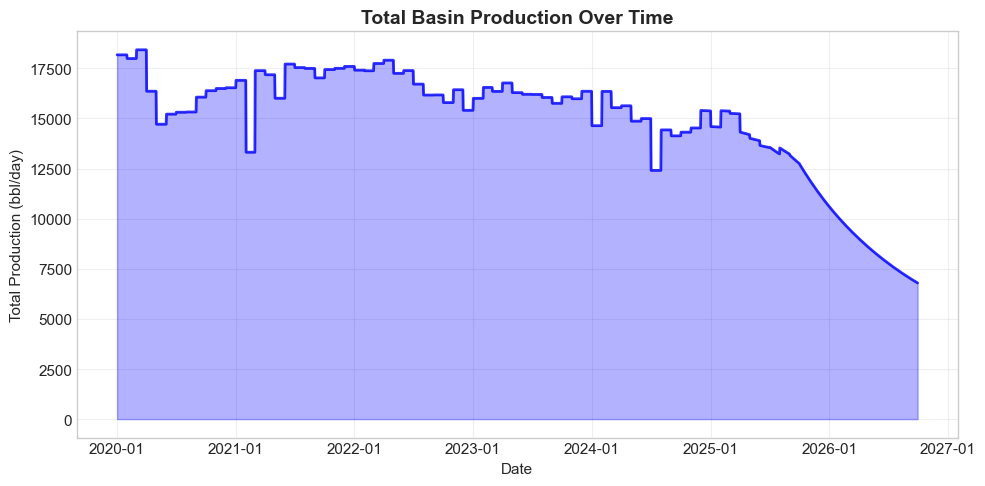

In [36]:
# Visualize results
fig, ax1 = plt.subplots(figsize=(10, 5))

daily_total = df_results.groupby('date')['daily_production'].sum()

ax1.plot(daily_total.index, daily_total.values,
         color='blue', linewidth=2, alpha=0.8)
ax1.fill_between(daily_total.index, daily_total.values,
                 alpha=0.3, color='blue')

ax1.set_xlabel('Date')
ax1.set_ylabel('Total Production (bbl/day)')
ax1.set_title('Total Basin Production Over Time',
              fontsize=14, fontweight='bold')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [16]:
import plotly.express as px

# Assuming daily_total is a pandas Series with datetime index
fig = px.line(daily_total.reset_index(), x='date', y='daily_production', 
              title='Total Basin Production Over Time')
fig.update_traces(fill='tozeroy', line=dict(color='blue', width=2))
fig.update_layout(xaxis_title='Date', yaxis_title='Total Production (bbl/day)')
fig.show()

In [38]:
# Data source breakdown
print("Data Source Analysis:")
print(df_results["data_source"].value_counts())
print()

# Per well summary
well_summary_results = df_results.groupby('api').agg({
    'daily_production': ['sum', 'mean', 'max'],
    'cumulative_production': 'max',
    'data_source': lambda x: (x == 'Actual').sum()
}).round(2)

well_summary_results.columns = ['total_production', 'avg_daily', 'max_daily', 'cumulative', 'actual_days']
well_summary_results = well_summary_results.sort_values('total_production', ascending=False)

print("Top 10 wells by total production:")
print(well_summary_results.head(10))
print()

# Wells with actual data
wells_with_actual = well_summary_results[well_summary_results['actual_days'] > 0]
print(f"Wells with actual data: {len(wells_with_actual)} out of {len(well_summary_results)}")
print(f"Average actual days per well: {wells_with_actual['actual_days'].mean():.1f}")

Data Source Analysis:
data_source
Actual       2619138
Simulated    1123678
Name: count, dtype: int64

Top 10 wells by total production:
                total_production  avg_daily  max_daily  cumulative  \
api                                                                  
42706404270002        842,480.62     341.92     828.23  842,480.62   
42201329880000        445,819.55     180.93     968.23  445,819.55   
42039333040000        392,808.33     159.42     442.24  392,808.33   
42039330800000        365,818.46     148.47     207.40  365,818.46   
42201329860000        345,111.53     140.06   1,095.03  345,111.53   
42039010600000        339,182.59     137.66     187.11  339,182.59   
42039011180000        338,678.10     137.45     256.55  338,678.10   
42039010840000        337,885.38     137.13     182.06  337,885.38   
42039011190000        297,042.23     120.55     183.13  297,042.23   
42039010750000        281,366.93     114.19     179.86  281,366.93   

                actual

## 10. Scenario Testing: Well Management Strategies

Test different well management scenarios using 12-month Simple Moving Average (SMA) of active wells:

1. **Aggressive**: Add `1 × 1.30 × SMA` new wells every month
2. **Steady**: Add `1 × 1.0 × SMA` new wells every month (baseline)
3. **Dormant**: Add `1 × 0.75 × SMA` new wells every month

Where SMA is the 12-month average of active wells. This creates more realistic well addition patterns based on recent basin activity.

In [28]:
import copy
from datetime import timedelta
from collections import deque

def calculate_sma_active_wells(active_wells_history, window=12):
    """
    Calculate Simple Moving Average of active wells over the last 'window' months.
    
    Args:
        active_wells_history: Deque of active well counts for each month
        window: Number of months for SMA (default 12)
    
    Returns:
        SMA value, or current active wells if less than window months
    """
    if len(active_wells_history) >= window:
        return sum(active_wells_history) / window
    elif len(active_wells_history) > 0:
        return sum(active_wells_history) / len(active_wells_history)
    else:
        return 0  # No history yet

def run_scenario(scenario_name, initial_well_configs, scenario_logic):
    """
    Run a simulation scenario with dynamic well management.

    Args:
        scenario_name: Name of the scenario
        initial_well_configs: List of initial well configurations
        scenario_logic: Function that takes (runner, current_date, step, active_wells_history) and performs well management

    Returns:
        DataFrame with simulation results
    """
    print(f"\n🚀 Running {scenario_name} scenario...")

    # Create fresh simulation runner
    runner = SimulationRunner(
        total_recoverable_resources=10_000_000_000,
        start_date=min(config['production_start_date'] for config in initial_well_configs),
        end_date=max(config['last_data_date'] for config in initial_well_configs) + timedelta(days=FORECAST_DAYS),
        basin_name='Houston Basin',
        market_center='Houston',
        country='UNITED STATES OF AMERICA',
    )

    # Add initial wells
    for config in initial_well_configs:
        try:
            runner.add_well(**config)
        except Exception as e:
            print(f"Error adding initial well {config['api_number']}: {e}")

    print(f"Initial wells: {len(initial_well_configs)}")

    # Calculate the end of historical data
    max_historical_date = max(config['last_data_date'] for config in initial_well_configs)
    print(f"Historical data ends: {max_historical_date}")

    # Track active wells history for SMA calculation
    active_wells_history = deque(maxlen=12)  # Keep last 12 months

    # Run simulation with scenario logic
    results = []
    runner.start()
    step = 0

    while runner.model.simulation_active:
        current_date = runner.model.current_date

        # Track active wells at the start of each month
        if current_date.day == 1:
            current_active = sum(1 for w in runner.model.basin_wells if w.is_active)
            active_wells_history.append(current_active)

        # Apply scenario-specific logic
        scenario_logic(runner, current_date, step, active_wells_history)

        # Step the simulation
        state = runner.step()
        step += 1

        sim_state = state['state']
        wells_data = []

        for well in sim_state['basin']['wells']:
            api = well.get('api_number', well['id'])
            wells_data.append({
                'date': current_date,
                'well_id': well['id'],
                'api': api,
                'daily_production': well['daily_production'],
                'cumulative_production': well['cumulative_production'],
                'is_active': well['is_active'],
                'scenario': scenario_name,
                'total_wells': len(sim_state['basin']['wells']),
            })

        results.extend(wells_data)

        # Progress updates
        if step % 100 == 0:
            total_prod = sum(w['daily_production'] for w in wells_data)
            active_count = sum(1 for w in wells_data if w['is_active'])
            print(f"  {scenario_name} - Day {step:4d} ({current_date.strftime('%Y-%m-%d')}): {total_prod:>8.1f} bbl/day | {active_count} active wells")

    print(f"✅ {scenario_name} scenario complete! {step} days processed.")
    return pl.DataFrame(results, schema={
        'date': pl.Datetime,
        'well_id': pl.Int64,
        'api': pl.Int64,
        'daily_production': pl.Float64,
        'cumulative_production': pl.Float64,
        'is_active': pl.Boolean,
        'scenario': pl.Utf8,
        'total_wells': pl.Int64,
    })

# Define scenario multipliers
SCENARIO_MULTIPLIERS = {
    "Steady": 1.0,
    "Aggressive": 1.30,
    "Dormant": 0.75
}

# Define scenario logic functions
def create_scenario_logic(scenario_name, max_historical_date, dim_averages):
    """Create scenario logic function with specific multiplier."""
    multiplier = SCENARIO_MULTIPLIERS[scenario_name]
    months_added = [0]  # Track months since historical end where wells were added
    
    def scenario_logic(runner, current_date, step, active_wells_history):
        """Add wells based on SMA and scenario multiplier."""
        # Add wells on the 1st of each month, only after historical data ends, for up to 6 months
        if (current_date > max_historical_date and current_date.day == 1 and step > 30 and 
            months_added[0] < 6):
            sma = calculate_sma_active_wells(active_wells_history, window=12)
            num_to_add = max(1, round(1 * multiplier * sma))
            
            print(f"    {scenario_name}: Month {months_added[0]+1}/6, SMA={sma:.1f}, Multiplier={multiplier}, Adding {num_to_add} wells")
            
            # Create new wells using dimension table averages
            for i in range(num_to_add):
                # Sample a random group from dim_averages
                dim_row = dim_averages.sample(1).to_dicts()[0]
                
                template_config = {
                    'api_number': int(current_date.strftime('%Y%m%d')) * 1000 + i,
                    'well_type': map_well_type(dim_row['well_type']),
                    'decline_type': 'Hyperbolic',  # Assume hyperbolic for new wells
                    'initial_production': max(dim_row['avg_qi'], 50.0),  # Ensure minimum
                    'nominal_decline_rate': dim_row['avg_di'],
                    'b_factor': dim_row['avg_b_factor'] if dim_row['avg_b_factor'] else 0.5,
                    'production_start_date': current_date,
                    'location': dim_row['basin_name'],
                    'basin': dim_row['basin_name'],
                    'actual_production_data': {},
                    'last_known_qi': max(dim_row['avg_qi'], 50.0),
                    'last_known_di': dim_row['avg_di'] / 12,
                    'last_data_date': current_date,
                    'is_new': True,
                }
                
                try:
                    runner.add_well(**template_config)
                    if i < 3:  # Only print first few to avoid spam
                        print(f"      Added well {template_config['api_number']}: Qi={template_config['initial_production']:.1f}, Di={template_config['nominal_decline_rate']:.4f}")
                except Exception as e:
                    print(f"      Error adding new well: {e}")
            
            months_added[0] += 1  # Increment after adding
    
    return scenario_logic

# Compute dimension averages for new well parameters
dim_averages = (
    dim
    .filter(pl.col('market_id') == 'Houston')  # Filter to Houston
    .group_by(['country', 'market_id', 'basin_name', 'well_type', 'start_year'])
    .agg([
        pl.col('Qi').mean().alias('avg_qi'),
        pl.col('Di').mean().alias('avg_di'),
        pl.col('b_factor').mean().alias('avg_b_factor'),
    ])
    .filter(pl.col('avg_qi').is_not_null() & pl.col('avg_di').is_not_null())
)

print(f"📊 Dimension averages computed: {dim_averages.shape[0]} groups")
dim_averages.head()

# Create scenario logic functions
max_historical_date = max(config['last_data_date'] for config in well_configs)

print(f"📅 Historical data ends on: {max_historical_date}")

steady_logic = create_scenario_logic("Steady", max_historical_date, dim_averages)
# aggressive_logic = create_scenario_logic("Aggressive", max_historical_date, dim_averages)
# dormant_logic = create_scenario_logic("Dormant", max_historical_date, dim_averages)

# Run all scenarios
scenarios = [
    ("Steady", steady_logic),
    # ("Aggressive", aggressive_logic),
    # ("Dormant", dormant_logic),
]

scenario_results = {}
for scenario_name, logic in scenarios:
    df_scenario = run_scenario(scenario_name, well_configs, logic)
    scenario_results[scenario_name] = df_scenario

No reserves data available for market_center='Houston'. Reserves tracking disabled.


📊 Dimension averages computed: 92 groups
📅 Historical data ends on: 2025-09-30 00:00:00

🚀 Running Steady scenario...
Initial wells: 1519
Historical data ends: 2025-09-30 00:00:00

📊 MONTHLY PRODUCTION BY GRADE - January 2020
   Market Center: Houston
   Heavy Sour  (hSour):        14,259.00 bbl
   Heavy Sweet (hSweet):            0.00 bbl
   Medium Sour (mSour):        95,584.00 bbl
   Medium Sweet(mSweet):      147,530.00 bbl
   Light Sour  (lSour):        69,955.00 bbl
   Light Sweet (lSweet):      236,091.00 bbl
   ────────────────────────────────────────
   TOTAL:                     563,419.00 bbl


📊 MONTHLY PRODUCTION BY GRADE - February 2020
   Market Center: Houston
   Heavy Sour  (hSour):        12,857.10 bbl
   Heavy Sweet (hSweet):            0.00 bbl
   Medium Sour (mSour):        90,462.71 bbl
   Medium Sweet(mSweet):      138,467.63 bbl
   Light Sour  (lSour):        65,535.63 bbl
   Light Sweet (lSweet):      214,443.93 bbl
   ────────────────────────────────────────
 

KeyboardInterrupt: 

In [27]:
df_scenario.tail()

shape: (5, 8)
┌─────────────┬─────────┬────────────┬────────────┬────────────┬───────────┬──────────┬────────────┐
│ date        ┆ well_id ┆ api        ┆ daily_prod ┆ cumulative ┆ is_active ┆ scenario ┆ total_well │
│ ---         ┆ ---     ┆ ---        ┆ uction     ┆ _productio ┆ ---       ┆ ---      ┆ s          │
│ datetime[μs ┆ i64     ┆ str        ┆ ---        ┆ n          ┆ bool      ┆ str      ┆ ---        │
│ ]           ┆         ┆            ┆ f64        ┆ ---        ┆           ┆          ┆ i64        │
│             ┆         ┆            ┆            ┆ f64        ┆           ┆          ┆            │
╞═════════════╪═════════╪════════════╪════════════╪════════════╪═══════════╪══════════╪════════════╡
│ 2026-09-29  ┆ 1516    ┆ 4248135356 ┆ 0.0        ┆ 0.0        ┆ true      ┆ Steady   ┆ 1519       │
│ 00:00:00    ┆         ┆ 0000       ┆            ┆            ┆           ┆          ┆            │
│ 2026-09-29  ┆ 1517    ┆ 4248135355 ┆ 0.0        ┆ 0.0        ┆ true      ┆ Steady   ┆ 1519       │
│ 00:00:00    ┆         ┆ 0000       ┆            ┆            ┆           ┆          ┆            │
│ 2026-09-29  ┆ 1518    ┆ 4215732990 ┆ 0.0        ┆ 0.0        ┆ true      ┆ Steady   ┆ 1519       │
│ 00:00:00    ┆         ┆ 0000       ┆            ┆            ┆           ┆          ┆            │
│ 2026-09-29  ┆ 1519    ┆ 4216731374 ┆ 0.0        ┆ 0.0        ┆ true      ┆ Steady   ┆ 1519       │
│ 00:00:00    ┆         ┆ 0003       ┆            ┆            ┆           ┆          ┆            │
│ 2026-09-29  ┆ 1520    ┆ 4215733200 ┆ 0.0        ┆ 0.0        ┆ true      ┆ Steady   ┆ 1519       │
│ 00:00:00    ┆         ┆ 0000       ┆            ┆            ┆           ┆          ┆            │
└─────────────┴─────────┴────────────┴────────────┴────────────┴───────────┴──────────┴────────────┘

## 11. Scenario Comparison and Analysis

In [59]:
# Combine all scenario results
df_all_scenarios = pl.concat(list(scenario_results.values()))

print("📊 SCENARIO COMPARISON SUMMARY")
print("=" * 60)

# Overall statistics by scenario
scenario_summary = (
    df_all_scenarios
    .group_by('scenario')
    .agg([
        pl.col('daily_production').sum().alias('total_production'),
        pl.col('daily_production').mean().alias('avg_daily_prod'),
        pl.col('daily_production').max().alias('peak_daily_prod'),
        pl.col('is_active').sum().alias('total_active_well_days'),
        pl.col('is_active').mean().alias('avg_active_wells'),
    ])
    .sort('total_production', descending=True)
)

print(scenario_summary)

# Monthly production trends
df_all_scenarios = df_all_scenarios.with_columns(
    pl.col('date').dt.month_start().alias('month')
)
monthly_prod = (
    df_all_scenarios
    .group_by(['scenario', 'month'])
    .agg(pl.col('daily_production').sum())
    .sort(['scenario', 'month'])
)

# Active wells over time
monthly_active = (
    df_all_scenarios
    .group_by(['scenario', 'month'])
    .agg(pl.col('is_active').sum())
    .sort(['scenario', 'month'])
)

print("\n📈 Key Insights:")
for row in scenario_summary.iter_rows(named=True):
    scenario = row['scenario']
    stats = row
    print(f"• {scenario}: {stats['total_production']:,.0f} bbl total, {stats['avg_daily_prod']:.1f} bbl/day avg, {stats['avg_active_wells']:.1f} wells active")

📊 SCENARIO COMPARISON SUMMARY
shape: (1, 6)
┌──────────┬─────────────────┬────────────────┬─────────────────┬─────────────────┬────────────────┐
│ scenario ┆ total_productio ┆ avg_daily_prod ┆ peak_daily_prod ┆ total_active_we ┆ avg_active_wel │
│ ---      ┆ n               ┆ ---            ┆ ---             ┆ ll_days         ┆ ls             │
│ str      ┆ ---             ┆ f64            ┆ f64             ┆ ---             ┆ ---            │
│          ┆ f64             ┆                ┆                 ┆ u32             ┆ f64            │
╞══════════╪═════════════════╪════════════════╪═════════════════╪═════════════════╪════════════════╡
│ Steady   ┆ 3.6863e7        ┆ 9.84899        ┆ 1095.033333     ┆ 3530556         ┆ 0.943289       │
└──────────┴─────────────────┴────────────────┴─────────────────┴─────────────────┴────────────────┘

📈 Key Insights:
• Steady: 36,862,959 bbl total, 9.8 bbl/day avg, 0.9 wells active


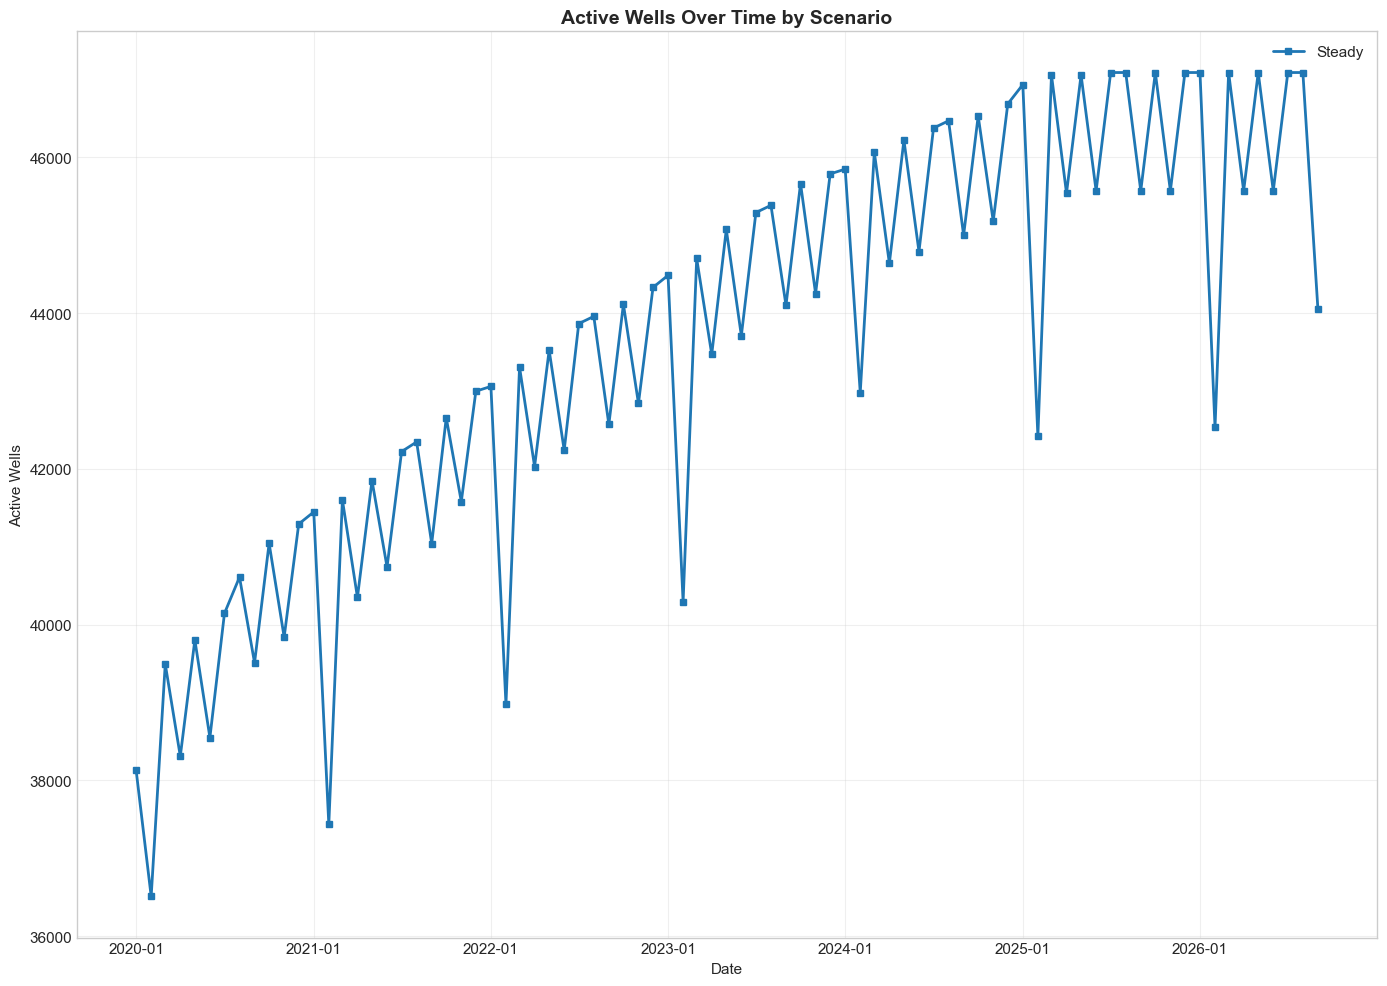

In [60]:
# Visualization: Production over time by scenario
fig, ax2 = plt.subplots(1, 1, figsize=(14, 10))



# Active wells over time
for scenario in scenarios:
    scenario_name = scenario[0]
    scenario_data = monthly_active.filter(pl.col('scenario') == scenario_name)
    ax2.plot(scenario_data['month'], scenario_data['is_active'],
             label=scenario_name, linewidth=2, marker='s', markersize=4)

ax2.set_title('Active Wells Over Time by Scenario', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Active Wells')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [61]:
# Calculate scenario performance metrics
print("\n📊 SCENARIO PERFORMANCE METRICS")
print("=" * 50)

# Add new columns to scenario_summary
scenario_summary = scenario_summary.with_columns([
    (pl.col('total_production') / pl.col('total_active_well_days')).alias('prod_per_well_day'),
    (pl.col('peak_daily_prod') / pl.col('avg_daily_prod')).alias('peak_to_avg_ratio')
])

print("Production Efficiency (bbl per active well-day):")
for row in scenario_summary.iter_rows(named=True):
    scenario = row['scenario']
    print(f"• {scenario}: {row['prod_per_well_day']:.2f}")

print("\nPeak to Average Production Ratio:")
for row in scenario_summary.iter_rows(named=True):
    scenario = row['scenario']
    print(f"• {scenario}: {row['peak_to_avg_ratio']:.2f}x")

# Final recommendations
print("\n🎯 SCENARIO RECOMMENDATIONS")
print("=" * 30)
print("• Aggressive (1.30x SMA): Highest growth and production, requires most capital")
print("• Steady (1.0x SMA): Balanced growth matching recent activity")
print("• Dormant (0.75x SMA): Conservative growth, lowest capital requirements")
print("• SMA-based approach provides adaptive well management based on basin performance")


📊 SCENARIO PERFORMANCE METRICS
Production Efficiency (bbl per active well-day):
• Steady: 10.44

Peak to Average Production Ratio:
• Steady: 111.18x

🎯 SCENARIO RECOMMENDATIONS
• Aggressive (1.30x SMA): Highest growth and production, requires most capital
• Steady (1.0x SMA): Balanced growth matching recent activity
• Dormant (0.75x SMA): Conservative growth, lowest capital requirements
• SMA-based approach provides adaptive well management based on basin performance
